# Analysis of National Energy Intensity Data and Socio-Demographic Factors

## Initialise and load data

In [1]:
import os 
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# For GWR, a pysal module (conda install -c conda-forge mgwr)
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# pysal and esda for GI* 
# (conda install -c conda-forge libpysal esda)
import libpysal
from esda.getisord import G_Local
# Contextily for adding basemaps
import contextily as cx

### Energy intensity data by Local Authority District (LAD)

Removed 969 duplicate areas (1292 -> 323)


<AxesSubplot:>

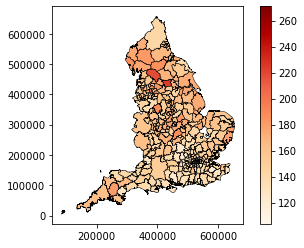

In [61]:
# Read data and make the index the LAD code (allows much easier joining to other data on LAD code)
energy_intensity = gpd.read_file(
    os.path.join("..", "01_Base_Posterior_Sampling/", "Sample_outputs", "energy_intensity_by_lad_since_2000.geojson"))
energy_intensity = energy_intensity.set_index("local_authority", drop=True)

# Drop LSOAs that don't have energy intensity data.
# Note that columns are currently strings, so need to find values with string 'NA',
# not a proper np.nan value.
energy_intensity = energy_intensity.loc[energy_intensity['energy_intensity_mean']!='NA']

# Drop duplicates (not sure why they are here)
count = len(energy_intensity)
energy_intensity = energy_intensity.drop_duplicates()
print(f"Removed {count-len(energy_intensity)} duplicate areas ({count} -> {len(energy_intensity)})")

# For some reason need to set the numeric columns to be floats 
for col in ['energy_intensity_1stQ', 'energy_intensity_mean',
            'energy_intensity_median', 'energy_intensity_3rdQ',
            'energy_intensity_sd', 'energy_intensity_national_mean',
            'mean_annual_income', 'top_rated_wall_insulation', 'secondary_heating',
            'social_rental', 'private_rental', 'standard_energy_tariff',
            'imd_mean_score',
            'imd_proportion_of_lsoas_in_most_deprived_decile_nationally',
            'heating_degree_days','income_before_housing']:
    # If there are NAs these need to be converted to a proper NA, not a string "NA",
    # otherwise astype() fails
    if (energy_intensity[col]=="NA").any():
        energy_intensity.loc[energy_intensity[col]=="NA", col] = np.nan
    energy_intensity[col] = energy_intensity[col].astype(float)

# Make it British National Grid
energy_intensity = energy_intensity.to_crs("EPSG:27700")

# Tidy up
del count

# Plot the energy intensity 
energy_intensity.plot(column="energy_intensity_mean", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)

### Demographic data

#### GIS Data

OA/LSOA/MSOA/LAD lookup so that we can move between different geographies.

From [data.gov.uk](https://data.gov.uk/dataset/ec39697d-e7f4-4419-a146-0b9c9c15ee06/output-area-to-lsoa-to-msoa-to-local-authority-district-december-2017-lookup-with-area-classifications-in-great-britain). Download and compress (it's big as a raw csv file) with
```bash
cd data/gis
wget http://geoportal1-ons.opendata.arcgis.com/datasets/fe6c55f0924b4734adf1cf7104a0173e_0.csv
gzip fe6c55f0924b4734adf1cf7104a0173e_0.csv
```

In [62]:
def get_msoa_column(df, lookup, df_col):
    """Return a Series that contains the MSOA code after doing a lookup for an LSOA or OA value
    in df.
    
    :param df: The input OA / LSOA dataframe
    :param lookup: A dict of '(ls)oa_code -> msoa_code'
    :param df_col: The column in df that represents the (LS)OA codes.
    """
    return df[df_col].apply(func=lambda x: lookup[x])

In [63]:
gis_lookup = pd.read_csv(os.path.join('data', 'gis', 'fe6c55f0924b4734adf1cf7104a0173e_0.csv.gz'))

# Make (LS)OA dictionary lookups
oa_dict = gis_lookup.set_index('OA11CD', drop=True).loc[:,'MSOA11CD'].to_dict()
lsoa_dict = gis_lookup.set_index('LSOA11CD', drop=True).loc[:,'MSOA11CD'].to_dict()
# Check the keys are unique (all keys in oa_dict should be different to those in lsoa_dict)
assert len(set(oa_dict.keys()).difference(set(lsoa_dict.keys()))) == len(oa_dict)
# Combine into a single dict
oa_dict.update(lsoa_dict)
msoa_lookup = oa_dict
assert len(msoa_lookup) == len(gis_lookup['OA11CD'].unique()) + len(gis_lookup['LSOA11CD'].unique())

del oa_dict, lsoa_dict

### House prices

There is a page on the ONS where you can download quite [detailed data](https://www.ons.gov.uk/datasets/house-prices-local-authority/editions/time-series/versions/6), but it seems really arduous to get all LADs. Instead I got [this table](http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/England-annual-price-change-by-local-authority-2021-03.csv?utm_medium=GOV.UK&utm_source=govuk&utm_campaign=England_annual_price_change_by_local_authority_2021_03&utm_term=19_05_21&utm_content=web_page) from a [summary page](https://www.gov.uk/government/statistics/uk-house-price-index-england-march-2021/uk-house-price-index-england-march-2021) and manually removed pound signs and percentages from the csv file.


In [64]:
house_price_lad = pd.read_csv(os.path.join("data", "house_price", "England-annual-price-change-by-local-authority-2021-03.csv"))
house_price_lad

,Local authorities,March 2021,March 2020,Difference
0,Adur,351112,310340,13.1
1,Allerdale,163403,152725,7.0
2,Amber Valley,203040,177602,14.3
3,Arun,310821,282352,10.1
4,Ashfield,167393,146590,14.2
...,...,...,...,...
334,Wychavon,297372,276262,7.6
335,Wyre,172597,153439,12.5
336,Wyre Forest,221782,200115,10.8
337,York,274112,257829,6.3


Fix some of the LAD names so that they match the energy price data (_this is actually a bit more annoying than I first thought so am ignoring for now_).

Merge to the energy data

Warning 30/323 LADs didn't join.
They are: ['Kingston upon Hull, City of' 'Derby' 'Nottingham'
 'Herefordshire, County of' 'Bristol, City of' 'Plymouth' 'Bournemouth'
 'Poole' 'Peterborough' 'Isles of Scilly' 'Aylesbury Vale' 'Chiltern'
 'South Bucks' 'Wycombe' 'Christchurch' 'East Dorset' 'North Dorset'
 'Purbeck' 'West Dorset' 'Weymouth and Portland' 'Shepway'
 "King's Lynn and West Norfolk" 'Taunton Deane' 'West Somerset'
 'Forest Heath' 'St Edmundsbury' 'Suffolk Coastal' 'Waveney' 'St. Helens'
 'Westminster']


<AxesSubplot:>

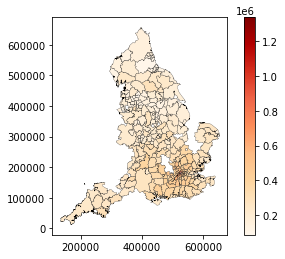

In [65]:
# Merge to the energy data. Need to reset and then set index otherwise we lose the lsoa code
energy_intensity = energy_intensity.reset_index().merge(house_price_lad[['Local authorities', 'March 2020']],
                                how="left", left_on="authority_name", right_on="Local authorities", validate="1:1"
                                ).set_index("local_authority")

# Sanity check the join (not currently because some areas do not join. Leaving for now)
if energy_intensity['March 2020'].isna().any():
    # Some didn't join
    fail = energy_intensity.loc[energy_intensity['March 2020'].isna()]
    print(f"Warning {len(fail)}/{len(energy_intensity)} LADs didn't join.\nThey are: {fail.authority_name.values}")
    #fail.plot()
else:
    print("Join successful, no misses")
        
    
energy_intensity['Local authorities'] = None
energy_intensity = energy_intensity.rename(columns={"March 2020": "mean_house_price"})

#energy_intensity.sample(4)
energy_intensity.plot(column="mean_house_price", cmap='OrRd', edgecolor='k', linewidth=0.2, legend=True)

#### Deprivation (IMD)

(NOTE: IMD is already available in the energy intensity data (columns `imd_mean_score` and `imd_proportion_of_lsoas_in_most_deprived_decile_nationally`) but these new data have more detail about the different domains).

Index of Multiple Deprivation (IMD) 2019

Source: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019

See [README.md](./data/imd/README.md) for details.

Note: there is a great infographic that explains the IMD and the diffent domains [here](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833959/IoD2019_Infographic.pdf).

In [70]:
imd_lsoa = pd.read_csv(os.path.join("data", "imd", 
                                    "File_2_-_IoD2019_Domains_of_Deprivation.csv.gz"))
imd_lsoa

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),Employment Rank (where 1 is most deprived),Employment Decile (where 1 is most deprived 10% of LSOAs),"Education, Skills and Training Rank (where 1 is most deprived)","Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)",Health Deprivation and Disability Rank (where 1 is most deprived),Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,29199,9,32831,10,32742,10,32842,10,32113,10,32662,10,7319,3,7789,3
1,E01000002,City of London 001B,E09000001,City of London,30379,10,29901,10,31190,10,32832,10,29705,10,32789,10,11707,4,13070,4
2,E01000003,City of London 001C,E09000001,City of London,14915,5,18510,6,15103,5,26386,9,17600,6,29363,9,2157,1,4092,2
3,E01000005,City of London 001E,E09000001,City of London,8678,3,6029,2,7833,3,12370,4,17907,6,31059,10,2217,1,9397,3
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,14486,5,14023,5,21692,7,17511,6,21581,7,18848,6,1033,1,10629,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32839,E01033764,Liverpool 022E,E08000012,Liverpool,116,1,90,1,176,1,565,1,113,1,1688,1,20598,7,14953,5
32840,E01033765,Liverpool 061D,E08000012,Liverpool,945,1,838,1,700,1,1781,1,942,1,3402,2,17379,6,21431,7
32841,E01033766,Liverpool 042G,E08000012,Liverpool,12842,4,16430,6,18004,6,20771,7,5694,2,15832,5,32228,10,778,1
32842,E01033767,Liverpool 050J,E08000012,Liverpool,422,1,442,1,550,1,1208,1,599,1,11728,4,26597,9,915,1


<AxesSubplot:>

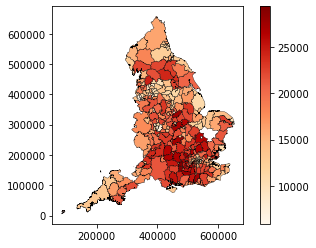

In [71]:
# Aggregate IMD data to local authority district (choose mean rank per LAD for each column)
# And also rename the columns at the same time
# (See https://www.statology.org/pandas-groupby-aggregate-multiple-columns/ for multiple aggregation)

# Define the old and new column names (can axis slice to get old (cols[:,0]) or new (cols[:,1]))
cols = np.array([('Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',"IMD_Rank"),
       ('Income Rank (where 1 is most deprived)', "IMD_Income"),
       ('Employment Rank (where 1 is most deprived)', "IMD_Employment"),
       ('Education, Skills and Training Rank (where 1 is most deprived)', "IMD_Education"),
       ('Health Deprivation and Disability Rank (where 1 is most deprived)',"IMD_Health"),
       ('Crime Rank (where 1 is most deprived)',"IMD_Crime"),
       ('Barriers to Housing and Services Rank (where 1 is most deprived)',"IMD_Housing"),
       ('Living Environment Rank (where 1 is most deprived)', "IMD_Environment")])

# Sanity check strings are actually columns names 
assert False not in [col in imd_lsoa.columns for col in cols[:,0] ]

# Rename
imd_lsoa = imd_lsoa.rename(columns={col[0]: col[1] for col in cols})

# Aggregate
imd_lad = imd_lsoa.groupby('Local Authority District code (2019)').agg({col: np.mean for col in cols[:,1]})
del cols  # (just because I use these later and don't want to get confused)

# Merge to the energy data
energy_intensity = energy_intensity.merge(imd_lad, how="left", left_index=True, right_index=True, validate="1:1")
# Sanity check the join (not currently because some areas do not join. Leaving for now)
#assert not energy_intensity[col].isna().any()
energy_intensity.sample(4)
energy_intensity.plot(column="IMD_Rank", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)

#### Tenure 

Table [QS405EW](https://www.nomisweb.co.uk/census/2011/qs405ew) (Tenure - Households). 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [9]:
tenure_lad = pd.read_csv(os.path.join("data", "census", "tenure-households-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Accommodation (Building) type

Table [QS402EW](https://www.nomisweb.co.uk/census/2011/qs402ew) (Accomodation type). 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [10]:
accommodation_type_lad = pd.read_csv(os.path.join("data", "census", "accommodation-type-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Household type

Table [QS116EW](https://www.nomisweb.co.uk/census/2011/qs116ew) - Household type. 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [11]:
building_type_lad = pd.read_csv(os.path.join("data", "census", "household-type-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Free school meal eligibility 

From: https://explore-education-statistics.service.gov.uk/find-statistics/free-school-meals-autumn-term/2020-21-autumn-term

In [66]:
fsm_lad = pd.read_csv(os.path.join("data", "free_school_meals", "free-school-meals-autumn-term_2020-21-autumn-term", "data", "fsm_new_starts_autumn20.csv")).set_index('new_la_code', drop=True)
# Drop data that aren't for LADs
fsm_lad = fsm_lad.dropna(subset=['la_name'])
# Each row is a different type of school. Sum the two rows we want across all school types in an LSOA
fsm_lad_grouped = fsm_lad.groupby(fsm_lad.index).agg({"fsm_eligible": np.sum, "headcount": np.sum})
fsm_lad_grouped['fsm_proportion'] = fsm_lad_grouped.fsm_eligible / fsm_lad_grouped.headcount

fsm_lad_grouped.sample(4)

,fsm_eligible,headcount,fsm_proportion
new_la_code,,,
E09000025,55006,255218,0.215526
E06000025,17676,159580,0.110766
E09000021,10760,106428,0.101101
E09000026,30196,232146,0.130073


Warning, no FSM data found for 203 areas


<AxesSubplot:>

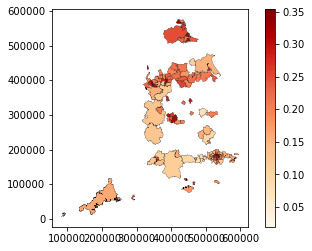

In [67]:
# Merge 
energy_intensity = energy_intensity.merge(fsm_lad_grouped, how="left", left_index=True, right_index=True)

if len(energy_intensity.loc[energy_intensity.fsm_proportion.isna()]) > 0:
    print(f"Warning, no FSM data found for {len(energy_intensity.loc[energy_intensity.fsm_proportion.isna()])} areas")
    
energy_intensity.plot(column="fsm_proportion", cmap='OrRd', edgecolor='k', linewidth=0.2, legend=True)

#### Sub-regional fuel poverty data 2021 
 
https://www.gov.uk/government/statistics/sub-regional-fuel-poverty-data-2021

In [14]:
#XXXX

## Basic correlations

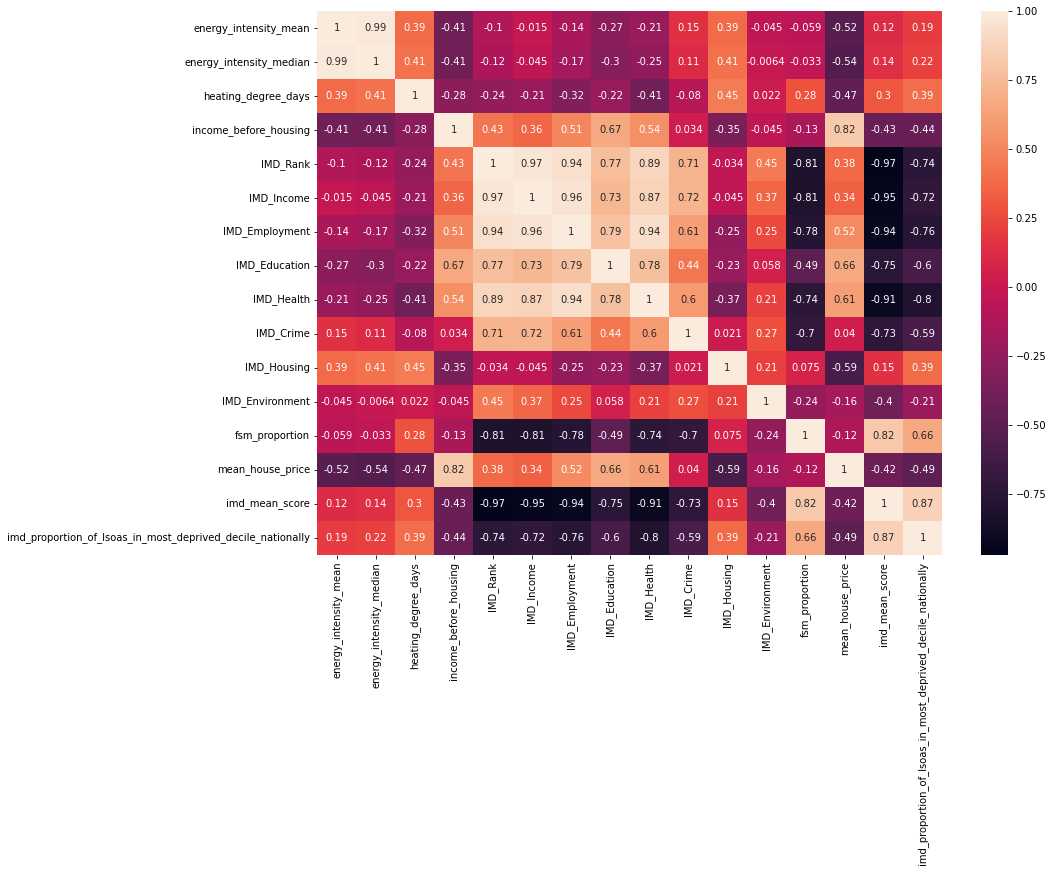

In [76]:
fig, ax = plt.subplots(figsize=(14,10))
cols = ['energy_intensity_mean', 'energy_intensity_median', 'heating_degree_days', 'income_before_housing',
        'IMD_Rank', 'IMD_Income', 'IMD_Employment',
        'IMD_Education', 'IMD_Health', 'IMD_Crime', 'IMD_Housing', 'IMD_Environment',
        'fsm_proportion', 'mean_house_price', 'imd_mean_score', 'imd_proportion_of_lsoas_in_most_deprived_decile_nationally']
sns.heatmap(energy_intensity[cols].corr(), annot=True, ax=ax)
del cols

Have a look at a couple of the correlations in more detail

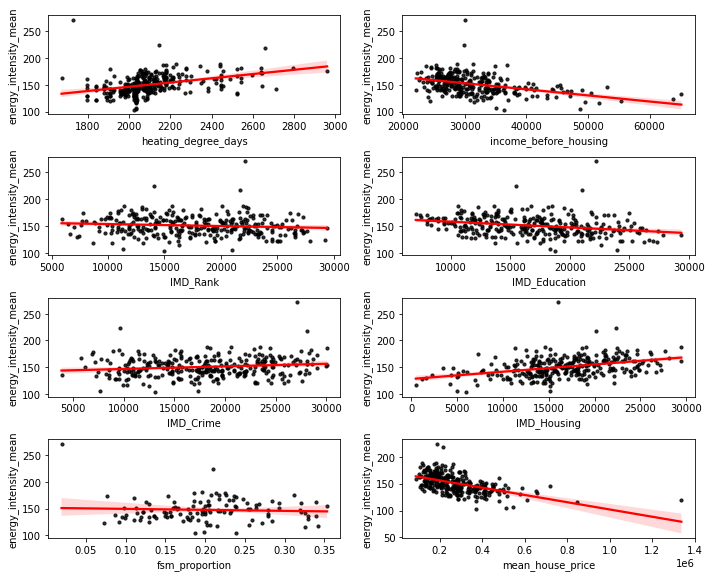

In [77]:
fig, axes = plt.subplots(4,2, figsize=(10,8))
cols = ['heating_degree_days', 'income_before_housing',
        'IMD_Rank', 'IMD_Education', 
        'IMD_Crime', 'IMD_Housing', 
        'fsm_proportion', 'mean_house_price',
       ]
yvar = 'energy_intensity_mean'
for ax, col in zip(axes.reshape(-1), cols):
    #ax.scatter(x=col, y=yvar, data=energy_intensity, label=col)
    #ax.set_ylim(0, max(energy_intensity.energy_intensity_mean))
    #ax.set_xlim(0, max(energy_intensity[col]))
    #ax.set_xlabel(col)
    #ax.set_ylabel(yvar)
    sns.regplot(x=energy_intensity[col], y=energy_intensity[yvar], label=col, ax=ax, 
               scatter_kws={'color':'black', 's':10},
               line_kws={'color':'red'}
               )
fig.tight_layout()
del col, cols

## Spatial Analysis

### Local Indicators of Spatial Autocorrelation.

Getis-Ord Local G (G*). See [pysal docs](https://pysal.org/esda/generated/esda.G_Local.html#esda.G_Local). 

References for the method:
 - Arthur Getis and J. K. Ord. The analysis of spatial association by use of distance statistics. Geographical Analysis, 24(3):189–206, Sep 2010. URL: http://dx.doi.org/10.1111/j.1538-4632.1992.tb00261.x
 - J. K. Ord and Arthur Getis. Local spatial autocorrelation statistics: distributional issues and an application. Geographical Analysis, 27(4):286–306, Sep 2010. URL: http://dx.doi.org/10.1111/j.1538-4632.1995.tb00912.x

In [78]:
# Need to temporarily drop isles of scilly and Isle of White because they are disconnected.
# This breaks the calculation of G later
energy_intensity = energy_intensity.drop(['E06000053', 'E06000046'])

/Users/nick/opt/anaconda3/envs/py39/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


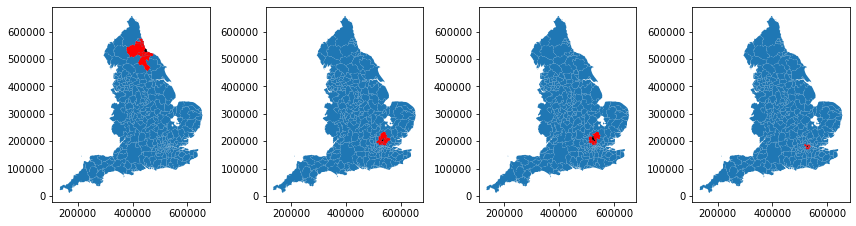

In [79]:
# Create spatial weights from points
THRESHOLD = 60000  # (This is a bit of trial and error. Too small and it creates islands)
#w = libpysal.weights.DistanceBand(lad_points,threshold=THRESHOLD)
#w = libpysal.weights.DistanceBand.from_dataframe(energy_intensity, threshold=THRESHOLD)
#w = libpysal.weights.Queen.from_dataframe(energy_intensity)
#w = libpysal.weights.Rook.from_dataframe(energy_intensity)
w = libpysal.weights.KNN.from_dataframe(energy_intensity, k=10)
#w = libpysal.weights.Kernel.from_dataframe(energy_intensity, fixed = False, function = 'gaussian', )
w.transform = "B"  # Using binary weights

# Check the weights (choose an area at random and plot it's connected areas
AREA_IDS = [0, 123, 250, 320]
fig, axes = plt.subplots(1, 4, figsize=(12,6))
for (area_id, ax) in zip(AREA_IDS, axes.reshape(-1)):
    neighbours = w.full()[0][area_id]
    energy_intensity.plot(ax=ax)
    energy_intensity.loc[[energy_intensity.index[area_id]]].plot(ax=ax, color='black')
    energy_intensity.loc[energy_intensity.index[neighbours.astype(bool)]].plot(ax=ax, color='red')
fig.tight_layout()

Text(0.5, 1.0, 'Number of neighbours')

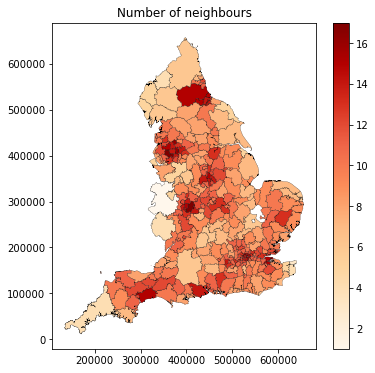

In [80]:
# Sanity check. Plot the number of neighbours to make sure that the final results
# (below) AREA_IDS = [0, 123, 250, 321]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
temp = energy_intensity.copy()
temp['num_neighbours'] = sum(w.full()[0])  # Index 0 has weights matrix, 1 has list of area names
temp.plot(ax=ax, column='num_neighbours', cmap='OrRd', edgecolor='k', alpha=1.0, linewidth=0.2, legend=True)
ax.set_title("Number of neighbours")
#del temp
# XXXX HERE Oh no, results are just reproducing the neighbours!

In [81]:
# Variable of interes
y = energy_intensity.energy_intensity_mean.values

In [82]:
# Applying Getis and Ord local G test using a binary weights object
g = G_Local(y, w, transform='B', star=True)

Can now access the following information (see [pysal docs](https://splot.readthedocs.io/en/stable/users/tutorials/autocorrelation.html#local-autocorrelation)):
 - `g.Gs`: the G* values (an array)
 - `g.p_sim`: simulated p values
 - `lg.p_sim[lg.p_sim<0.05]`: significant G value

In [83]:
# Attach information back to the energy_intensity dataframe
energy_intensity['Gs'] = g.Gs
energy_intensity['Zs'] = g.Zs
energy_intensity['Gs_psig'] = g.p_sim
energy_intensity['Gs_sig'] = g.p_sim<0.05

Plot the (Z score) of the GI* values, masking out insignificant ones.

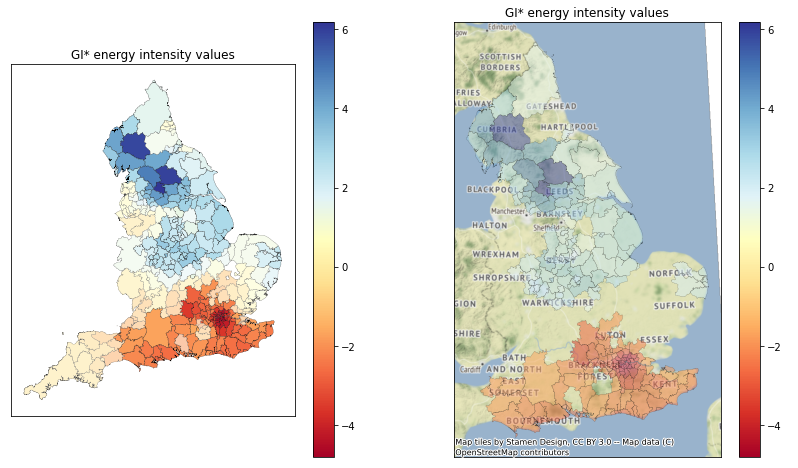

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
ax1 = axes[0]
ax2 = axes[1]

# What to map, and colours
# col = 'Gs' # G values
col = 'Zs' # Z values
colour_map = "RdYlBu"
#colour_map = "OrRd"

# Plot without basemap
ax1.set_title("GI* energy intensity values")
energy_intensity.plot(column=col, cmap=colour_map, edgecolor='k', alpha=1.0, 
                      linewidth=0.2, legend=True, ax=ax1)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# Mask out non significant
energy_intensity.loc[~energy_intensity.Gs_sig]\
        .plot(alpha=0.5, color="white", edgecolor='k', linewidth=0.0, ax=ax1)

# Plot with basemap (ignoring non significant)
ax2.set_title("GI* energy intensity values")
energy_intensity[energy_intensity.Gs_sig]\
    .plot(column=col, cmap=colour_map, edgecolor='k', alpha=0.5, linewidth=0.2, legend=True, ax=ax2)
cx.add_basemap(ax2, crs=energy_intensity.crs)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


Shows clusters of higher energy intensity in the north and lower in the south.

### Geographically Weighted Regression (GWR)

Build a regression model that allows its coefficients to vary across space.

Uses the `mgwr` module in pysal, following [this Geogria example](https://pysal.org/notebooks/model/mgwr/GWR_Georgia_example.html)

Note: can easily paralelise the GWR calculation (see [here](https://pysal.org/notebooks/model/mgwr/GWR_MGWR_Parallel_Example.html)) but it runs quickly on these data so probably not worth it

Prepare the data

In [163]:
#Predictors
x_columns = ['heating_degree_days', 'income_before_housing', 'imd_mean_score']
y_column = 'energy_intensity_mean'

# Need to drop any areas with any NAs in the Xs
# Slightly confusing 'loc' because we want to drop rows that have values missing in the 
# x_columns, but don't want to lose all the other columns
energy_intensity_gwr = energy_intensity.loc[energy_intensity[x_columns].dropna().index]
print(f"Dropped {len(energy_intensity)-len(energy_intensity_gwr)} rows that had an NA in one of the predictor variables"+
      f"({len(energy_intensity)}->{len(energy_intensity_gwr)})")

# Centroids of each area
coords = list(zip(energy_intensity_gwr.centroid.x, energy_intensity_gwr.centroid.x))

# Prepare the list structures for the variables
y = energy_intensity_gwr[y_column].values.reshape((-1,1))  # (makes shape (321,1))
X = energy_intensity_gwr[x_columns].values  # (shape (321,3)))

# Transform them
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)



Dropped 25 rows that had an NA in one of the predictor variables(321->296)


Calibrate GWR model

In [164]:
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=2)
print(f"Bandwidth: {gwr_bw}")
gwr_results = GWR(coords, y, X, gwr_bw).fit()

Bandwidth: 253.0


In [165]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 296
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            203.793
Log-likelihood:                                                    -364.764
AIC:                                                                737.528
AICc:                                                               739.734
BIC:                                                              -1457.792
R2:                                                                   0.312
Adj. R2:                                                              0.304

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [166]:
gwr_results.params  # (note: param 0 is the intercept)

array([[ 0.07792442,  0.28812371, -0.45911067, -0.16873192],
       [ 0.07433126,  0.29350961, -0.45881177, -0.17246181],
       [ 0.05879984,  0.32199427, -0.45442882, -0.19155089],
       ...,
       [-0.00549218,  0.43536118, -0.41417543, -0.22562811],
       [-0.00453074,  0.42756504, -0.41687341, -0.22795667],
       [-0.00474456,  0.42873211, -0.41645553, -0.22768875]])

In [167]:
gwr_results.localR2[0:10]

array([[0.2697883 ],
       [0.27930976],
       [0.31690907],
       [0.26126958],
       [0.23098309],
       [0.18454123],
       [0.18591144],
       [0.18649092],
       [0.18102988],
       [0.37022684]])

Attach the results back to the main dataframe

In [168]:
energy_intensity_gwr['gwr_R2'] = gwr_results.localR2
energy_intensity_gwr['gwr_intercept'] = gwr_results.params[:,0]
for i, col in enumerate(x_columns):
    energy_intensity_gwr[f"gwr_{col}"] = gwr_results.params[:,i+1]
energy_intensity_gwr

,authority_name,energy_intensity_1stQ,energy_intensity_mean,energy_intensity_median,energy_intensity_3rdQ,energy_intensity_sd,energy_intensity_national_mean,mean_annual_income,top_rated_wall_insulation,secondary_heating,...,IMD_Environment,Gs,Zs,Gs_psig,Gs_sig,gwr_R2,gwr_intercept,gwr_heating_degree_days,gwr_income_before_housing,gwr_imd_mean_score
local_authority,,,,,,,,,,,,,,,,,,,,,
E06000001,Hartlepool,106.073333,143.271946,138.330141,175.353579,52.404853,200.058522,25430.0,0.224348,0.170435,...,27155.258621,0.036075,1.531261,0.046,True,0.269788,0.077924,0.288124,-0.459111,-0.168732
E06000002,Middlesbrough,100.977831,147.258582,139.983444,186.147487,62.904632,200.058522,25344.0,0.417699,0.203540,...,22755.395349,0.035420,0.975957,0.137,False,0.279310,0.074331,0.293510,-0.458812,-0.172462
E06000003,Redcar and Cleveland,121.383589,172.193727,164.638713,214.877348,70.994129,200.058522,26049.0,0.334783,0.195652,...,27083.090909,0.035420,0.975957,0.261,False,0.316909,0.058800,0.321994,-0.454429,-0.191551
E06000004,Stockton-on-Tees,107.210963,146.917925,141.812166,181.075738,54.914440,200.058522,27778.0,0.325234,0.168224,...,28638.850000,0.036503,1.893584,0.022,True,0.261270,0.077837,0.281575,-0.458634,-0.162020
E06000005,Darlington,119.668328,175.462789,166.971534,222.448935,77.699608,200.058522,28524.0,0.302405,0.211340,...,25341.538462,0.036503,1.893584,0.064,False,0.230983,0.080037,0.268852,-0.450326,-0.141876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E09000029,Sutton,79.905389,125.099652,116.817772,162.101389,61.942005,200.058522,33570.0,0.457594,0.055227,...,15132.561983,0.029259,-4.243524,0.001,True,0.368691,-0.004651,0.428203,-0.416644,-0.227814
E09000030,Tower Hamlets,69.174336,117.649573,108.649110,156.329181,64.938639,200.058522,49500.0,0.553290,0.054680,...,8245.638889,0.029231,-4.267622,0.001,True,0.367209,-0.005443,0.434539,-0.414449,-0.225931
E09000031,Waltham Forest,90.161168,135.133549,127.967233,172.766180,61.398945,200.058522,38023.0,0.460606,0.084848,...,7450.006944,0.028957,-4.499478,0.001,True,0.366987,-0.005492,0.435361,-0.414175,-0.225628


XXXX HERE - map the coefficients